### Imports

In [2]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [3]:
trail_size=14
predict_length = 5
time_period = '6y'

### Load data

In [4]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH', 'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI', 'UMC','ANET','EPAM', 'UI','XM',
'GIB','TRMB', 'TYL','WIX','HPE','LYFT', 'LOGI', 'MPWR']
top10tech = top100tech[:10]

In [5]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [6]:
traditional_energy_stocks = [
    "LNG",
    "OKE",
    "BKR",
    "WMB",
    "EQT", 
    "XEC", 
    "XOM", 
    "CVX", 
    "BP", 
    "OXY", 
    "COP", 
    "EOG", 
    "COG", 
    "CNQ", 
    "SLB", 
    "PTR", 
    "TOT", 
    "ENB",  
]

In [7]:
data = get_data_yf(traditional_energy_stocks + [x for x in top_energy if x not in traditional_energy_stocks], time_period)

[*********************100%***********************]  33 of 33 completed


In [8]:
data.isna().sum().sum()

0

In [9]:
data = process_stock_data_from_yf(data)

In [10]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

### Compute technical indicators

In [11]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Load climate trends data

In [12]:
filenames = [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
]
filenames = [
    "data climate change.csv",
    "data greenhouse gas.csv",
    "data oil.csv",
    "data renewable.csv",
    "data carbon tax.csv",
    "data electric vehicles.csv",
    "data environmental protection agency.csv",
    "data fossil fuels.csv",
    "data fracking.csv",
    "data global warming.csv",
]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [13]:
climate_trends_data = load_climate_data(filenames, terms)

In [14]:
climate_trends_data

Term,Date,carbon tax,climate change,electric vehicles,environmental protection agency,fossil fuels,fracking,global warming,greenhouse gas,oil,renewable
0,2015-01-01,13,29,67,0,22,22,30,0,64,17
1,2015-01-02,34,27,19,23,14,21,31,18,78,28
2,2015-01-03,83,24,41,47,20,21,36,44,80,29
3,2015-01-04,35,30,20,23,33,35,40,36,75,24
4,2015-01-05,40,42,60,10,33,27,54,16,89,56
...,...,...,...,...,...,...,...,...,...,...,...
2267,2021-03-17,88,57,60,56,53,17,65,54,87,75
2268,2021-03-18,88,57,64,56,64,14,77,66,86,73
2269,2021-03-19,57,52,40,29,61,14,56,75,86,69
2270,2021-03-20,54,41,55,32,32,6,41,41,99,39


In [17]:
climate_features = [x for x in climate_trends_data.columns.tolist() if x !="Date"]

In [18]:
climate_features

['carbon tax',
 'climate change',
 'electric vehicles',
 'environmental protection agency',
 'fossil fuels',
 'fracking',
 'global warming',
 'greenhouse gas',
 'oil',
 'renewable']

In [19]:
num_climate_features = len(climate_features)

<AxesSubplot:xlabel='Date'>

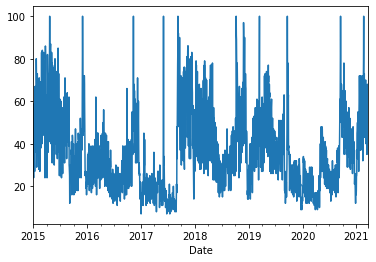

In [20]:
climate_trends_data.set_index('Date')['climate change'].plot()

### Choose features

In [21]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)

### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize the data within each year, because the stock will tend to have different averages in different years
3. We will want to normalize each different company differently, because the stocks will be of differing magnitudes

### Train test split

In [22]:
train = dataset.loc[dataset['Date'] < "2018-03-01"]
valid = dataset.loc[(dataset['Date'] > "2018-03-13") & (dataset['Date'] < "2019-03-01")]
test = dataset.loc[(dataset['Date'] > "2019-03-01") & (dataset['Date'] < "2020-03-01")]

#### Per stock normalization
We make sure to fit the transforms on the training, and
apply them on training, validation, and test

In [23]:
scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


#### split data into historical vs technical
(close, open, high, low) vs (BBH, ADX, SD, MA, SMA... etc. )


In [24]:
hist_features = [x for x in features if x in ['Close', 'High',
 'Low', 'Open', 'Volume',]]
tech_features = [x for x in features if x in ['HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']]


#### Merge in climate features

In [25]:
train = train.merge(climate_trends_data, on=["Date"], how='left')
valid = valid.merge(climate_trends_data, on=["Date"], how='left')
test = test.merge(climate_trends_data, on=["Date"], how='left')

In [26]:
xh_train, xt_train, y_train, tickers_train = split_and_roll_all_stocks(train, trail_size, predict_length, hist_features+climate_features, tech_features)
xh_valid, xt_valid, y_valid, tickers_valid = split_and_roll_all_stocks(valid, trail_size, predict_length, hist_features+climate_features, tech_features)
xh_test, xt_test, y_test, tickers_test = split_and_roll_all_stocks(test, trail_size, predict_length, hist_features+climate_features, tech_features)

#### Prepare training inputs and outputs
Convert the daily data points into a set of data points each with {trail_size} days.   
We keep track of the tickers so we can later inverse the normalization with the right model. 

In [27]:
# x_train, y_train, tickers_train = roll_all_stocks(train, trail_size, predict_length)
# x_valid, y_valid, tickers_valid = roll_all_stocks(valid, trail_size, predict_length)
# x_test, y_test, tickers_test = roll_all_stocks(test, trail_size, predict_length)

#### Confirm shapes

In [28]:
print("xh_train: {}".format(xh_train.shape))
print("xt_train: {}".format(xt_train.shape))
print("y_train: {}".format(y_train.shape))
print("xh_valid: {}".format(xh_valid.shape))
print("xt_valid: {}".format(xt_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("xh_test: {}".format(xh_test.shape))
print("xt_test: {}".format(xt_test.shape))
print("y_test {}".format(y_test.shape))

xh_train: (23694, 14, 15)
xt_train: (23694, 24)
y_train: (23694,)
xh_valid: (7392, 14, 15)
xt_valid: (7392, 24)
y_valid (7392,)
xh_test: (7688, 14, 15)
xt_test: (7688, 24)
y_test (7688,)


In [29]:
print("tickers_train: {}".format(tickers_train.shape))
print("tickers_valid: {}".format(tickers_valid.shape))
print("tickers_test: {}".format(tickers_test.shape))

tickers_train: (23694,)
tickers_valid: (7392,)
tickers_test: (7688,)


### Model design

In [31]:
# inputs
historical_input = Input(shape=(trail_size, len(hist_features)+len(climate_features)))
technical_input = Input(shape=(len(tech_features)))

# historical data branch
x = LSTM(units=75, return_sequences=True)(historical_input)
x = Dropout(0.25)(x)
x = LSTM(units=30, return_sequences=True)(x)
x = Dropout(0.25)(x)
x = LSTM(units=30, return_sequences=True)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Model(inputs=historical_input, outputs=x)

# technical indicators branch
y = Dense(20)(technical_input)
y = Dropout(0.25)(y)
y = Dense(15)(y)
y = Dropout(0.25)(y)
y = Dense(10)(y)
y = Model(inputs=technical_input, outputs=y)

# combine the model
c = concatenate([x.output, y.output])
c = Dense(5)(c)
c = Dense(1, activation='linear')(c)

model = Model(inputs=[x.input, y.input], outputs=c)


In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 15)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 14, 75)       27300       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 75)       0           lstm[0][0]                       
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24)]         0                                            
____________________________________________________________________________________________

In [33]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [34]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train on many stocks

In [35]:
history1 = model.fit(x=[xh_train, xt_train], 
                     y=y_train, 
                     epochs=30, 
                     validation_data=([xh_valid, xt_valid], y_valid), 
                     batch_size=64, 
                     shuffle=False, 
                     callbacks=[tensorboard])

Epoch 1/30
371/371 [==============================] - 10s 17ms/step - loss: 0.0597 - val_loss: 0.0899
Epoch 2/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0158 - val_loss: 0.0373
Epoch 3/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0130 - val_loss: 0.0330
Epoch 4/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0117 - val_loss: 0.1178
Epoch 5/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0107 - val_loss: 0.0514
Epoch 6/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0097 - val_loss: 0.0565
Epoch 7/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0093 - val_loss: 0.0253
Epoch 8/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0088 - val_loss: 0.0550
Epoch 9/30
371/371 [==============================] - 4s 10ms/step - loss: 0.0081 - val_loss: 0.0134
Epoch 10/30
371/371 [==============================] - 4s 11ms/step - loss: 0.0079 - val_l

### Prepare data for one stock

In [36]:
target_stock = "LNG"

In [37]:
single_stock_dataset = dataset[dataset['Ticker']==target_stock].reset_index(drop=True)

<AxesSubplot:xlabel='Date', ylabel='Close'>

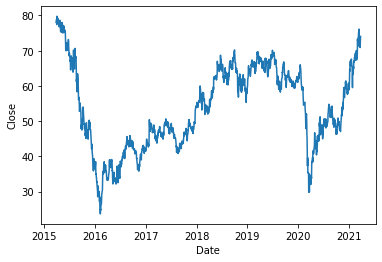

In [38]:
sns.lineplot(x=single_stock_dataset['Date'], y=single_stock_dataset['Close'])

### Train test split

In [39]:
train = single_stock_dataset.loc[single_stock_dataset['Date'] < "2018-03-01"]
valid = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2018-03-13") & (single_stock_dataset['Date'] < "2019-03-01")]
test = single_stock_dataset.loc[(single_stock_dataset['Date'] > "2019-03-01") & (single_stock_dataset['Date'] < "2020-03-01")]

In [40]:
single_stock_scaler_models = norm_per_stock_split(train, valid, test, features, MinMaxScaler)

C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\jaker\miniconda3\envs\finance\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is tryin

#### Merge in climate trends data

In [41]:
train = train.merge(climate_trends_data, on=["Date"], how='left')
valid = valid.merge(climate_trends_data, on=["Date"], how='left')
test = test.merge(climate_trends_data, on=["Date"], how='left')

#### Prepare training inputs and outputs
Since we are using just one stock, we don't need to keep track of tickers

In [42]:
xh_train, xt_train, y_train, _ = split_and_roll_all_stocks(train, trail_size, predict_length, hist_features+climate_features, tech_features)
xh_valid, xt_valid, y_valid, _ = split_and_roll_all_stocks(valid, trail_size, predict_length, hist_features+climate_features, tech_features)
xh_test, xt_test, y_test, _ = split_and_roll_all_stocks(test, trail_size, predict_length, hist_features+climate_features, tech_features)

#### Confirm shapes

In [43]:
print("xh_train: {}".format(xh_train.shape))
print("xt_train: {}".format(xt_train.shape))
print("y_train: {}".format(y_train.shape))
print("xh_valid: {}".format(xh_valid.shape))
print("xt_valid: {}".format(xt_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("xh_test: {}".format(xh_test.shape))
print("xt_test: {}".format(xt_test.shape))
print("y_test {}".format(y_test.shape))

xh_train: (718, 14, 15)
xt_train: (718, 24)
y_train: (718,)
xh_valid: (224, 14, 15)
xt_valid: (224, 24)
y_valid (224,)
xh_test: (233, 14, 15)
xt_test: (233, 24)
y_test (233,)


### Test model on single stock

In [44]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict([xh_train, xt_train]), 
                                                      y_train,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

Training RMSE = 2.8962930888752223


In [45]:
print("Validation RMSE = {}".format(evaluate_model_rmse(model.predict([xh_valid, xt_valid]), 
                                                      y_valid,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

Validation RMSE = 3.1111415869286603


In [46]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict([xh_test, xt_test]), 
                                                     y_test,
                                                    num_features,
                                                    single_stock_scaler_models[target_stock])))

Testing RMSE = 3.3499598897681926


In [47]:
for layer in model.layers:
    layer.trainable=False

In [48]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [49]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 15)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 14, 75)       27300       input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 75)       0           lstm[0][0]                       
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24)]         0                                            
____________________________________________________________________________________________

In [50]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model on single stock

In [51]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [52]:
history2 = model.fit([xh_train, xt_train], 
                     y_train, 
                     epochs=45, 
                     validation_data=([xh_valid, xt_valid], y_valid), 
                     batch_size=64, 
                     shuffle=False, 
                     callbacks=[tensorboard])

Epoch 1/45
12/12 [==============================] - 7s 383ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 2/45
12/12 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 3/45
12/12 [==============================] - 0s 8ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 4/45
12/12 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 5/45
12/12 [==============================] - 0s 8ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 6/45
12/12 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 7/45
12/12 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0031
Epoch 8/45
12/12 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0031
Epoch 9/45
12/12 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0031
Epoch 10/45
12/12 [==============================] - 0s 8ms/step - loss: 0.0056 - val_loss: 0.0031
Epoch 11/45
12/12

### Visualize results

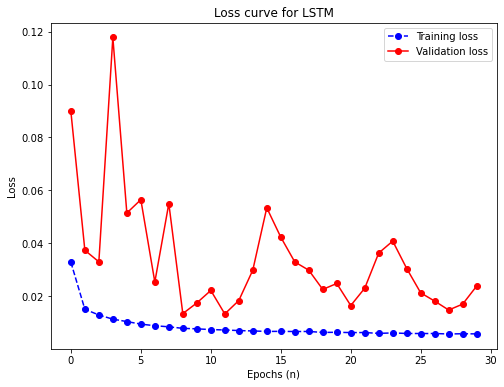

In [53]:
plot_loss(history1)

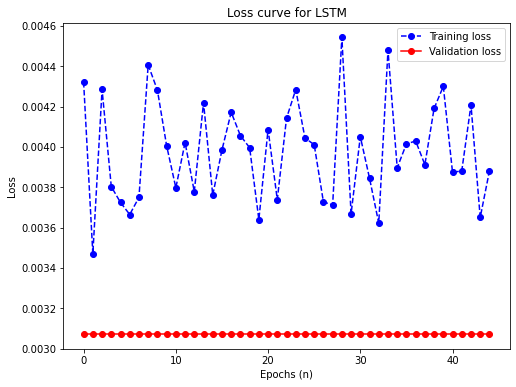

In [54]:
plot_loss(history2)

In [55]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict([xh_train, xt_train]), 
                                                      y_train,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

Training RMSE = 2.8962930888752223


In [56]:
print("Validation RMSE = {}".format(evaluate_model_rmse(model.predict([xh_valid, xt_valid]), 
                                                      y_valid,
                                                     num_features,
                                                     single_stock_scaler_models[target_stock])))

Validation RMSE = 3.1111415869286603


In [57]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict([xh_test, xt_test]), 
                                                     y_test,
                                                    num_features,
                                                    single_stock_scaler_models[target_stock])))

Testing RMSE = 3.3499598897681926


#### Compare to simple baseline

In [58]:
def predict_no_change(x):
    return x[-1][0]

In [59]:
no_change_preds = np.array([predict_no_change(x) for x in xh_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [60]:
evaluate_model_rmse(no_change_preds, y_train, num_features, single_stock_scaler_models[target_stock])

2.320932805383209

In [61]:
no_change_preds = np.array([predict_no_change(x) for x in xh_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [62]:
evaluate_model_rmse(no_change_preds, y_train, num_features, single_stock_scaler_models[target_stock])

2.320932805383209

In [63]:
no_change_preds = np.array([predict_no_change(x) for x in xh_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [64]:
evaluate_model_rmse(no_change_preds, y_test, num_features, single_stock_scaler_models[target_stock])

2.1111315617936537

### Plot data against predictions

In [65]:
pd.DataFrame([y_train, model.predict([xh_train, xt_train])[:, 0]]).T

,0,1
0,0.955639,0.866236
1,0.934794,0.873053
2,0.921254,0.876453
3,0.923214,0.900664
4,0.941386,0.915771
...,...,...
713,0.580616,0.595362
714,0.571174,0.594043
715,0.581151,0.589670
716,0.552646,0.599219


<AxesSubplot:title={'center':'Training performance'}>

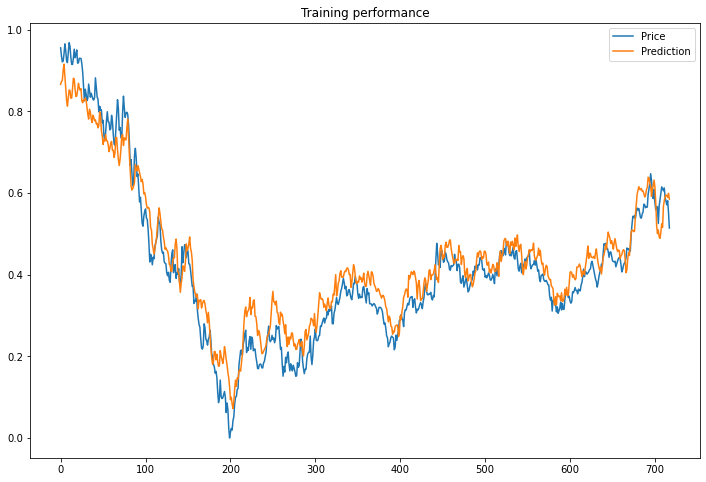

In [66]:
price_vs_preds = pd.DataFrame([y_train, model.predict([xh_train, xt_train])[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Training performance")

<AxesSubplot:title={'center':'Validation performance'}>

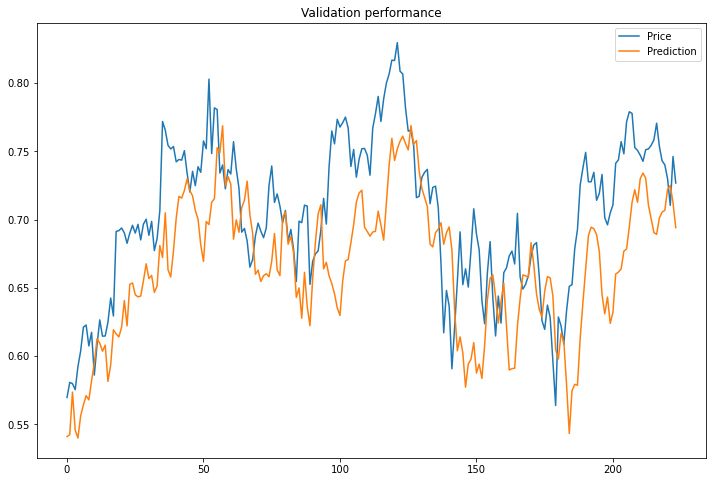

In [67]:
price_vs_preds = pd.DataFrame([y_valid, model.predict([xh_valid, xt_valid])[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Validation performance")

<AxesSubplot:title={'center':'Testing performance'}>

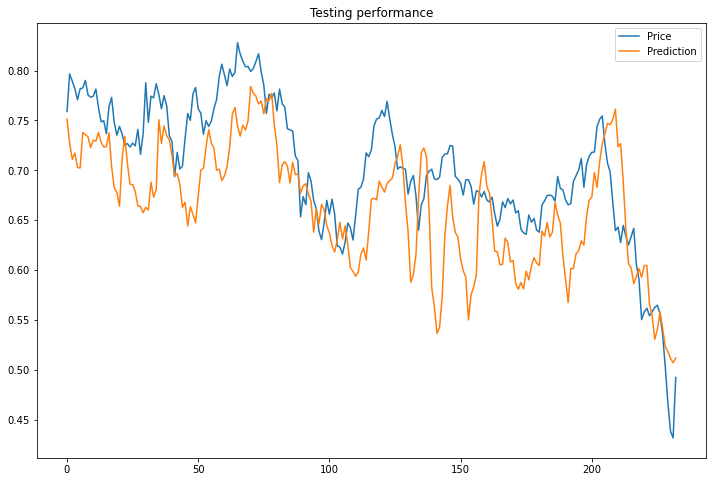

In [68]:
price_vs_preds = pd.DataFrame([y_test, model.predict([xh_test, xt_test])[:, 0]]).T
price_vs_preds.columns = ['Price', 'Prediction']
price_vs_preds.plot(figsize=(12,8), title="Testing performance")